## 目录
1. 因子比较与筛选
2. 常用的因子预处理方法-调整正负、去极值、行业市值中性化、标准化
3. 多因子组合方法

In [1]:
from jaqs.data import DataView 
import warnings

warnings.filterwarnings("ignore")
dataview_folder = '../../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)
dv.add_formula("momentum", "Return(close_adj, 20)", is_quarterly=False)

Dataview loaded successfully.


In [2]:
import numpy as np

def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = ~(df_index_member >0) #定义信号过滤条件-非指数成分
    return mask_index_member

def limit_up_down():
    # 定义可买卖条件——未停牌、未涨跌停
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == u'停牌'
    # 涨停
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False)
    # 跌停
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

mask = mask_index_member()
can_enter,can_exit = limit_up_down()

接下来，我们对pb、pe、ps、float_mv、momentum五个因子进行比较、筛选

In [3]:
from jaqs.research import SignalDigger
from jaqs.research.signaldigger import performance as pfm

obj = SignalDigger()
signal_data = dict()
ic = dict()

for signal in ["pb","pe","ps","float_mv","momentum"]:
    signal_data[signal] = dict()
    ic[signal] = dict()
    for period in [5, 15, 30]:
        obj.process_signal_before_analysis(signal=dv.get_ts(signal),
                                           price=dv.get_ts("close_adj"),
                                           high=dv.get_ts("high_adj"), # 可为空
                                           low=dv.get_ts("low_adj"),# 可为空
                                           n_quantiles=5,# quantile分类数
                                           mask=mask,# 过滤条件
                                           can_enter=can_enter,# 是否能进场
                                           can_exit=can_exit,# 是否能出场
                                           period=period,# 持有期
                                           benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                           commission = 0.0008,
                                           )
        signal_data[signal][period] = obj.signal_data
        ic[signal][period] = pfm.calc_signal_ic(obj.signal_data)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective da

In [4]:
import pandas as pd
ic_mean_table = pd.DataFrame(data=np.nan,columns=[5,15,30],index=["pb","pe","ps","float_mv","momentum"])
ic_std_table = pd.DataFrame(data=np.nan,columns=[5,15,30],index=["pb","pe","ps","float_mv","momentum"])
ir_table = pd.DataFrame(data=np.nan,columns=[5,15,30],index=["pb","pe","ps","float_mv","momentum"])
for signal in ["pb","pe","ps","float_mv","momentum"]:
    for period in [5, 15, 30]:
        ic_mean_table.loc[signal,period]=ic[signal][period].mean().values[0]
        ic_std_table.loc[signal,period]=ic[signal][period].std().values[0]
        ir_table.loc[signal,period]=ic[signal][period].mean().values[0]/ic[signal][period].std().values[0]

print(ic_mean_table)
print(ic_std_table)
print(ir_table)

                5         15        30
pb       -0.045915 -0.077320 -0.117015
pe       -0.038581 -0.064546 -0.095852
ps       -0.030755 -0.054824 -0.084486
float_mv -0.000019  0.008395  0.027459
momentum -0.049655 -0.062483 -0.058243
                5         15        30
pb        0.229864  0.258433  0.245398
pe        0.211099  0.222946  0.215375
ps        0.178680  0.198704  0.193410
float_mv  0.220951  0.228495  0.223991
momentum  0.203428  0.212723  0.208409
                5         15        30
pb       -0.199748 -0.299188 -0.476838
pe       -0.182763 -0.289515 -0.445044
ps       -0.172122 -0.275909 -0.436822
float_mv -0.000084  0.036740  0.122589
momentum -0.244090 -0.293731 -0.279466


可视化比较

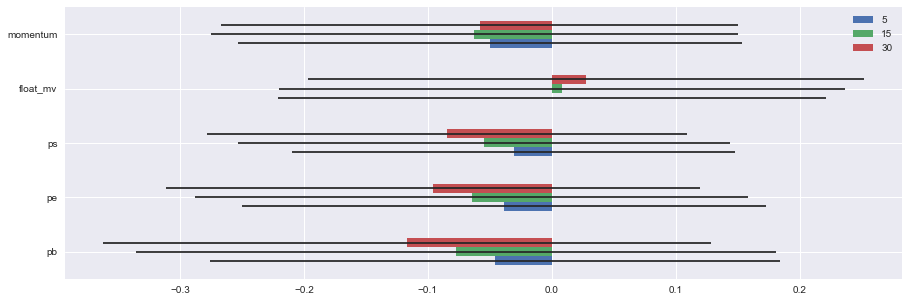

In [5]:
%matplotlib inline
ic_mean_table.plot(kind="barh",xerr=ic_std_table,figsize=(15,5))

* IC_IR:方差标准化后的ic均值
* 一般而言，认为|IC_IR|>0.6,因子的稳定性合格

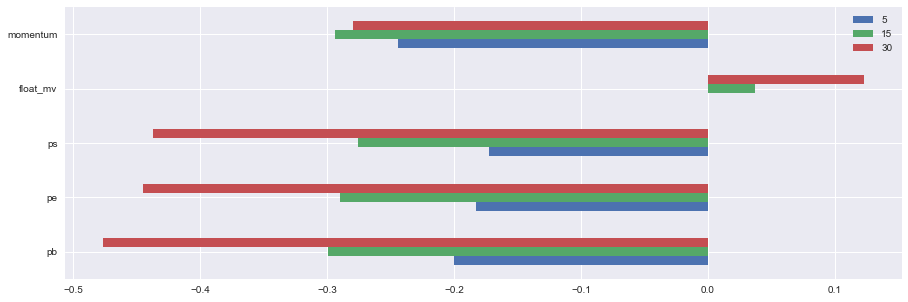

In [6]:
%matplotlib inline
ir_table.plot(kind="barh",figsize=(15,5))

### 因子预处理
保留momentum、ps、pe、pb 进一步处理并尝试构建组合因子

* 根据之前的分析，这几个因子在几个持有期下与股票收益的关系（ic）都是负的，先统一调整成正相关关系
* 去极值
* 标准化 -- z-score、rank
* 行业市值中性化


In [7]:
from jaqs.research.signaldigger import process

factor_dict = dict()
index_member = dv.get_ts("index_member")
for name in ["pb","pe","ps","momentum"]:
    signal = -1*dv.get_ts(name) # 调整符号
    process.winsorize(factor_df=signal,alpha=0.05,index_member=index_member)#去极值
    signal = process.standardize(signal,index_member) #z-score标准化 保留排序信息和分布信息
#     signal = process.rank_standardize(signal,index_member) #因子在截面排序并归一化到0-1(只保留排序信息)
    #行业市值中性化
#     signal = process.neutralize(signal,
#                                 factorIsMV=False,#是否是市值类因子
#                                 group_field="sw1",#行业分类类型　"sw1", "sw2", "sw3", "sw4", "zz1", "zz2"
#                                 index_member=index_member,# 是否只处理时只考虑指数成份股
#                                 dv=dv,#dataview
#                                 ds=None) #data_api
    factor_dict[name] = signal

### 多因子组合
对筛选后的因子进行组合，一般有以下常规处理：
* 因子间存在较强同质性时，先使用施密特正交化方法对因子做正交化处理，用得到的正交化残差作为因子（也可以不使用，正交化会破坏因子的经济学逻辑，并剔除一些信息）
* 因子组合加权，常规的方法有：等权重、以某个时间窗口的滚动平均ic为权重、以某个时间窗口的滚动ic_ir为权重、最大化上个持有期的ic_ir为目标处理权重、最大化上个持有期的ic为目标处理权重
* 注:因为计算IC需要用到下一期股票收益,因此在动态加权方法里，实际上使用的是前一期及更早的IC值(向前推移了holding_period)计算当期的权重

In [ ]:
from jaqs.research.signaldigger import multi_factor

In [ ]:
# 因子间存在较强同质性时，使用施密特正交化方法对因子做正交化处理，用得到的正交化残差作为因子
new_factors = multi_factor.orthogonalize(factors_dict=factor_dict,
                           standardize_type="rank",#输入因子标准化方法，有"rank"（排序标准化）,"z_score"(z-score标准化)两种（"rank"/"z_score"）
                           winsorization=False,#是否对输入因子去极值
                           index_member=index_member) #　是否只处理指数成分股

In [ ]:
new_factors

用正交化前的因子，分别进行等权、以某个时间窗口的滚动平均ic为权重、以某个时间窗口的滚动ic_ir为权重、最大化上个持有期的ic_ir为目标处理权重、最大化上个持有期的ic为目标处理权重的加权组合方式，然后测试组合因子表现

In [ ]:
# rollback_period代表滚动窗口所用到的天数,即用前多少期的数据来计算现阶段的因子权重。 通常建议设置时间在半年以上,可以获得相对稳定的预期结果

#  多因子组合-动态加权参数配置
props = {
    'price':dv.get_ts("close_adj"),
    'high':dv.get_ts("high_adj"), # 可为空
    'low':dv.get_ts("low_adj"),# 可为空
    'ret_type': 'return',#可选参数还有upside_ret/downside_ret 则组合因子将以优化潜在上行、下行空间为目标
    'benchmark_price': dv.data_benchmark,  # 为空计算的是绝对收益　不为空计算相对收益
    'period': 30, # 30天的持有期
    'mask': mask,
    'can_enter': can_enter,
    'can_exit': can_exit,
    'forward': True,
    'commission': 0.0008,
    "covariance_type": "shrink",  # 协方差矩阵估算方法 还可以为"simple"
    "rollback_period": 120}  # 滚动窗口天数

In [ ]:
comb_factors = dict()
for method in ["equal_weight","ic_weight","ir_weight","max_IR","max_IC"]:
    comb_factors[method] = multi_factor.combine_factors(factor_dict,
                                                        standardize_type="rank",
                                                        winsorization=False,
                                                        weighted_method=method,
                                                        props=props)
    print(method)
    print(comb_factors[method].dropna(how="all").head())

### 比较组合前和组合后的因子在30日持有期下的表现（统一到2014年9月后进行比较）

In [ ]:
# 处理组合因子的signal_data
period = 30
for method in ["equal_weight","ic_weight","ir_weight","max_IR","max_IC"]:
    signal_data[method] = dict()
    obj.process_signal_before_analysis(signal=comb_factors[method],
                                       price=dv.get_ts("close_adj"),
                                       high=dv.get_ts("high_adj"), # 可为空
                                       low=dv.get_ts("low_adj"),# 可为空
                                       n_quantiles=5,# quantile分类数
                                       mask=mask,# 过滤条件
                                       can_enter=can_enter,# 是否能进场
                                       can_exit=can_exit,# 是否能出场
                                       period=period,# 持有期
                                       benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                       commission = 0.0008,
                                       )
    signal_data[method][period] = obj.signal_data

In [ ]:
ic_30 = dict()
ic_30_mean = dict()
ic_30_std = dict()
ir_30 = dict()
for name in signal_data.keys():    
    ic_30[name] = pfm.calc_signal_ic(signal_data[name][30].loc[20140901:,:])
    if name in ["pb","pe","ps","momentum"]:
        ic_30[name] = -1*ic_30[name]
    ic_30_mean[name]=ic_30[name].mean().values[0]
    ic_30_std[name]=ic_30[name].std().values[0]
    ir_30[name] = ic_30_mean[name]/ic_30_std[name]

In [ ]:
import datetime

ic_30_df = pd.concat(ic_30.values(),axis=1)
ic_30_df.columns = ic_30.keys()
trade_date = pd.Series(ic_30_df.index)
trade_date = trade_date.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
ic_30_df.index = trade_date

可视化比较

In [ ]:
pd.Series(ic_30_mean).plot(kind="barh",xerr=pd.Series(ic_30_std),figsize=(15,5))

In [ ]:
print(ic_30_mean["equal_weight"])
print(ic_30_mean["ic_weight"])
print(ic_30_mean["pe"])

In [ ]:
pd.Series(ir_30).plot(kind="barh",figsize=(15,5))

In [ ]:
print(ir_30["equal_weight"])
print(ir_30["ic_weight"])
print(ir_30["pe"])

In [ ]:
ic_30_df[["equal_weight","ic_weight","pe"]].plot(kind="line",figsize=(15,5),)

In [ ]:
ic_30_df.loc[datetime.date(2017,1,3):,][["equal_weight","ic_weight","pe"]].plot(kind="line",figsize=(15,5),)

### 查看等权合成因子的详情报告

In [ ]:
import matplotlib.pyplot as plt
from jaqs.research.signaldigger.analysis import analysis

def draw_analysis(signal_data,period):  
    obj.signal_data = signal_data
    obj.period = period
    obj.create_full_report()
    plt.show()
    
def factor_stats(signal_data, is_event, period):
    return(analysis(signal_data, is_event=is_event, period=period))

In [ ]:
draw_analysis(signal_data["equal_weight"][30],period=30)

In [ ]:
print(factor_stats(signal_data["equal_weight"][30],False,30))

进一步测试下等权合成因子的绝对收益效果

In [ ]:
obj.process_signal_before_analysis(signal=comb_factors["equal_weight"],
                                       price=dv.get_ts("close_adj"),
                                       high=dv.get_ts("high_adj"), # 可为空
                                       low=dv.get_ts("low_adj"),# 可为空
                                       n_quantiles=5,# quantile分类数
                                       mask=mask,# 过滤条件
                                       can_enter=can_enter,# 是否能进场
                                       can_exit=can_exit,# 是否能出场
                                       period=30,# 持有期
                                       #benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                       commission = 0.0008,
                                       )
obj.create_full_report()
plt.show()

## 将Quantile5的选股结果保存成excel

In [ ]:
excel_data = obj.signal_data[obj.signal_data['quantile']==5]["quantile"].unstack().replace(np.nan, 0).replace(5, 1)
print (excel_data.head())
excel_data.to_excel('./equal_weight_quantile_5.xlsx')